#Dataset Partitioning
In this notebook the execution time to partition the dataset using **median** method and **2-Means clustering** will be evaluated. 

In addition, two metrics will be defined that are used for the assessment of information loss in the anonymization scenario.



#Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from itertools import permutations

%matplotlib inline

#Import CSV file

In [ ]:
url = 'https://raw.githubusercontent.com/stegianna/mondrian/master/local/dataset/adults.csv'
df = pd.read_csv(url)

print(df)

       age         workclass  ...  native-country income
0       39         State-gov  ...   United-States  <=50K
1       50  Self-emp-not-inc  ...   United-States  <=50K
2       38           Private  ...   United-States  <=50K
3       53           Private  ...   United-States  <=50K
4       28           Private  ...            Cuba  <=50K
...    ...               ...  ...             ...    ...
32556   27           Private  ...   United-States  <=50K
32557   40           Private  ...   United-States   >50K
32558   58           Private  ...   United-States  <=50K
32559   22           Private  ...   United-States  <=50K
32560   52      Self-emp-inc  ...   United-States   >50K

[32561 rows x 13 columns]


In [ ]:
age = df['age'].to_numpy()
print(age)
educd = df['education-num'].to_numpy()
print(educd)
educd = df['hours-per-week'].to_numpy()
print(educd)

quasi_id = ['age', 'education-num', 'hours-per-week']

[39 50 38 ... 58 22 52]
[13 13  9 ...  9  9  9]
[40 13 40 ... 40 20 40]


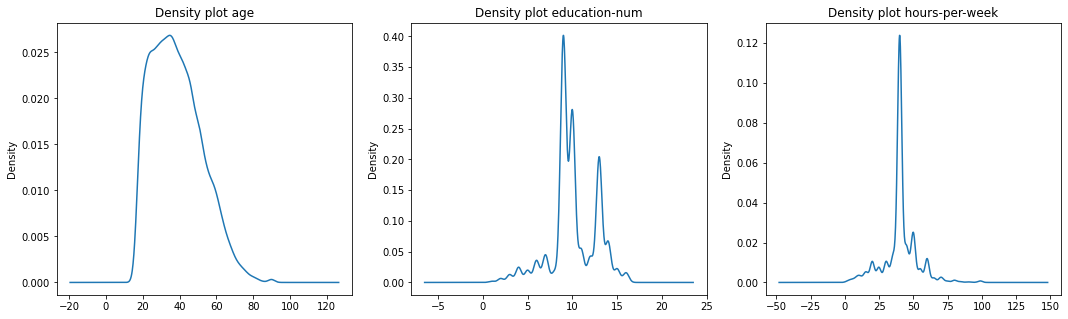

In [ ]:
plt.figure(figsize=(18,5))
for i, qi in enumerate(quasi_id):
    plt.subplot(1,len(quasi_id),i+1)
    df[qi].plot(kind='density')
    plt.title("Density plot %s" %qi)

plt.show()

#K-means++ Implementation
For each data point the distance is calculated in relation to the more closeness centroid

Let D(x) denote the shortest distance
from a data point x to the closest center we have already chosen.

Steps of the algorithm
1. Choose an initial center $c_1$ uniformly at random
from X.
2. Choose the next center $c_i$ selecting $c_i = x^{'} \in X$
with probability $\frac{D(x^{'})^2}{\sum_{x \in X} D(x)^2}$
3. Repeat Step 2 until we have chosen a total of k
centers.
4. Proceed as with the standard **k-means** algorithm.

In [ ]:
def dist_from_center(X, mu):
    D2 = np.array([min([np.linalg.norm(x-c)**2 for c in mu]) for x in X])
    return D2


def choose_next_center(X, mu, D2):
    try:
        probs = D2/D2.sum()
        #print(probs)
        new_center = np.random.choice(X, p=probs)
    except:
        new_center = np.random.choice(X[[x not in mu for x in X]],1)
    mu.append(new_center)

def get_init_centers(X, K):
    mu = list(np.random.choice(X,1))
    for _ in range(K-1):
        D2 = dist_from_center(X,mu)
        choose_next_center(X, mu, D2)
    return mu

#Lloyd Algorithm Implementation
Algorithm for K-means clustering.

Lloyd's algorithm starts by an initial placement of some number k of point sites in the input domain.

In [ ]:
def clustering(X, mu):
    clusters = dict()
    for x in X:
        best_mu = min([(i[0], np.linalg.norm(x-i[1])) \
            for i in enumerate(mu)], key=lambda k:k[1])
        try:
            clusters[best_mu[0]].append(x)
        except KeyError:
            clusters[best_mu[0]] = [x]
    #print(clusters)
    return clusters


def reevaluate_centroids(clusters):
    newmu = []
    for k in sorted([*clusters]):
        newmu.append(np.mean(clusters[k]))
    return newmu

def has_converged(oldmu, mu):
    return oldmu == mu


def compute_lloyd(X, K, method='random'):
    if method == 'random':
        # Initialize to K random centers
        mu = list(np.random.choice(X, K))
    elif method == 'kmeans++':
        mu = get_init_centers(X,K)
    else:
        raise Exception(f"method: {method} is not defined")
    
    while True:
        oldmu = mu
        # Assign all points in X to clusters
        clusters = clustering(X, mu)
        # Reevaluate centers
        mu = reevaluate_centroids(clusters)
        if has_converged(oldmu, mu):
            break
    return mu, clusters, iter

#Partitioning Function
`partitioning` function produces the maximum number of partitions with at least `min_size` elements in according to the cutting method specified (median, 2-means)

In [ ]:
def partitioning(df, min_size, quasi_id, method='median', init_method=None):
    if method != 'median' and method != '2means':
        raise Exception(f"{method} method is invalid")
    if method == 'median' and init_method is not None:
        raise Exception(f"{method} method has not 'init_method' argument")
    if method == '2means' and init_method is None:
        raise Exception(f"{method} method requires 'init_method' argument")
    if method == '2means' and init_method not in ['kmeans++', 'random']:
        raise Exception(f"{init_method} is not valid for {method} method")
    
    partitions = [df.index]
    result = []
    if method == 'median':
        while partitions:
            perm = list(permutations(quasi_id))
            index = np.random.choice(np.arange(len(perm)))
            columns = list(perm[index])
            part = partitions.pop(0)
            for column in columns:
                dfl, dfr, median = cut_column_median(df[column][part])
                if is_valid(df[column][dfl], min_size) and is_valid(df[column][dfr], min_size):
                    partitions.append(dfl)
                    partitions.append(dfr)
                    break
            else:
                result.append(part)
    elif method == '2means':
        while partitions:
            perm = list(permutations(quasi_id))
            index = np.random.choice(np.arange(len(perm)))
            columns = list(perm[index])
            part = partitions.pop(0)
            for column in columns:
                if not is_kmeans_valid(df[column][part]):
                    continue
                dfl, dfr = cut_column_2means(df[column][part], init_method)
                #print(f"len dfl: {len(df[column][dfl])}")
                #print(f"len dfr: {len(df[column][dfr])}")
                if is_valid(df[column][dfl], min_size) and is_valid(df[column][dfr], min_size):
                    partitions.append(dfl)
                    partitions.append(dfr)
                    break
            else:
                result.append(part)
    return result
        
    
def cut_column_median(ser):
    median = ser.median()
    dfl = ser.index[ser < median]
    dfr = ser.index[ser >= median]
    return (dfl, dfr, median)
        


def cut_column_2means(ser, init_method):
    #print(f"len series: {len(ser)}")
    mu, clusters, iter = compute_lloyd(ser.to_numpy(),2,method=init_method)
    #print(f"len cluster 0: {len(clusters[0])}")
    #print(f"len cluster 1: {len(clusters[1])}")
    #print(f"len sum clusters: {len(clusters[0])+len(clusters[1])}")
    dfl = ser.index[[value in clusters[0] for value in ser.to_numpy()]]
    dfr = ser.index[[value in clusters[1] for value in ser.to_numpy()]]
    #print('--------------------------')
    return (dfl, dfr)

def is_valid(partition, size):
    return len(partition.index) >= size


def is_kmeans_valid(df):
    arr = df.to_numpy()
    return not all(x == arr[0] for x in arr)

# Metrics Definition
 **Discernability penalty** \\
It is defined as $DP =\sum_{equiv class E} |E|^2$

**Normalized certainty penalty** \\
 Let T be a table with quasi-identifier $(A_1, \dots, A_n)$, where all attributes are numeric. Suppose a tuble $t = (x_1, \dots, t_n)$ is generalized to tuple $t^{'} = ([y_1,z_1], \dots, [y_n,z_n])$ such that $y_i \le x_i \le z_i$. 
 
 On attribute $A_i$ the normalized penalty is defined as 

 $NCP_{A_i}(t) = \frac{z_i-y_i}{|A_i|}$ 
 
where $|A_i| = max_{t \in T}\{t.A_i\} - min_{t \in T} \{t.A_i\}$ is the range of all tubles on attribute $A_i$



In [ ]:
def discernability_penalty(partitions):
    return np.array(list(map(lambda x: len(x)**2, partitions))).sum()

def normalized_certainty_penalty(df, partitions, quasi_id):
    NCP = 0
    for attr in quasi_id:
        max_all = max(df[attr])
        min_all = min(df[attr])
        NCP += sum(list(map(lambda x: (max(df[attr][x])-min(df[attr][x]))/(max_all-min_all)*len(x),partitions)))
    return NCP

#Main

In [ ]:
#@title Partitioning Arguments Selection

min_size = "3" #@param {type:"string"}
min_size = int(min_size)
print('minimum size:', min_size)

method = "median" #@param ["median", "2means"]
print('method:', method)

init_method = "kmeans++" #@param ["random", "kmeans++"]
print('init method:', init_method)

minimum size: 3
method: median
init method: kmeans++


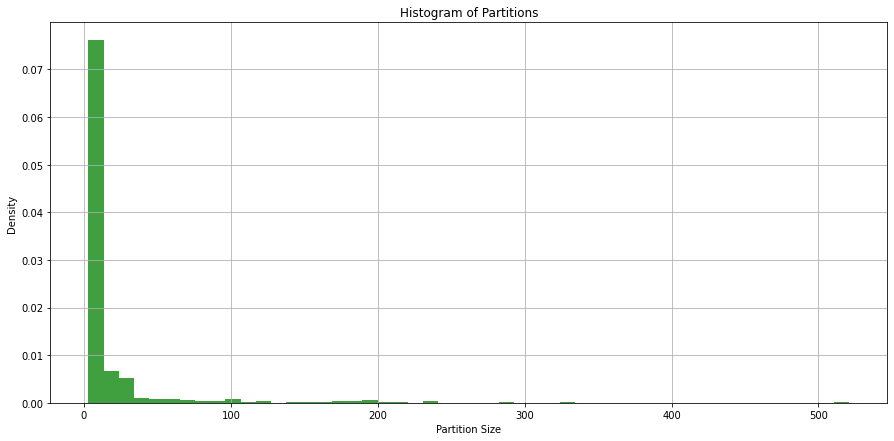

In [ ]:
start = time.time()
partitions = partitioning(df, min_size, quasi_id, method=method, init_method=None)
end = time.time()

part_size = list(map(len, partitions))
plt.figure(figsize=(15,7))
plt.hist(part_size, 50, density=True, facecolor='g', alpha=0.75)
plt.xlabel('Partition Size')
plt.ylabel('Density')
plt.title('Histogram of Partitions')
plt.grid(True)
plt.show()

In [ ]:
#print(df.iloc[partitions[1], :])
print(f"Execution time: {end-start}s")
print("Total partitions:", len(partitions))

print("Discernability penalty =", discernability_penalty(partitions))
print("Normalized certainty penalty =", normalized_certainty_penalty(df, partitions, quasi_id))

print(sum(part_size))

Execution time: 10.439936399459839s
Total partitions: 1718
Discernability penalty = 4666769
Normalized certainty penalty = 12227.083244804806
32561
